In [45]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u



plt.rcParams['pdf.fonttype']=42
ko_mice = stx.ymaze_sess_deets.ko_mice

ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
# ctrl_mice = [m for m in ctrl_mice if m not in ('mCherry6')]

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [46]:

def run_shuffle(sess, starts, stops, rng, last_block_only=False):
    spks = sess.timeseries['spks']
    spks_shuff = np.zeros(spks.shape)
    
    lr = sess.trial_info['LR']
    
    if last_block_only:
        trial_starts = sess.trial_start_inds[sess.trial_info['block_number']==5]
        teleports = sess.teleport_inds[sess.trial_info['block_number']==5]
        
        lr = lr[sess.trial_info['block_number']==5]
    else:
        trial_starts = starts
        teleports = stops
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _spks = 1*spks[:,start:stop]    
        _spks = np.roll(_spks,rng.integers(0,stop-start),axis=-1)
        spks_shuff[:,start:stop] = 1*_spks
        
    tmat = tpu.spatial_analyses.trial_matrix(spks_shuff.T,sess.timeseries['t'].ravel(), trial_starts,
                                                                     teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    nov_mean = np.nanmean(tmat[lr==sess.novel_arm, :, :], axis=0)
    fam_mean = np.nanmean(tmat[lr==-1*sess.novel_arm, :, :], axis=0)
    return nov_mean, fam_mean


# find trial mask
rng = np.random.default_rng()
nperms = 1000
shuff_results = {}

for mice in (ctrl_mice, ko_mice):
    for mouse in mice:
        shuff_results[mouse] = {}
        for day in range(6):
            try:
                sess = u.load_single_day(mouse, day)
            except FileNotFoundError:
                print(f"File not found for mouse {mouse}, day {day}. Skipping.")
                continue
            except Exception as e:
                print(f"Error loading session for mouse {mouse}, day {day}: {e}")
                continue

            shuff_results[mouse][day] = {}
            trial_masks = sess.trial_matrices['downsample']
            try:
                starts = sess.trial_start_inds[trial_masks]
                stops = sess.teleport_inds[trial_masks]
            except IndexError as e:
                print(f"Indexing error for mouse {mouse}, day {day}: {e}. Skipping")
                continue
            except Exception as e:
                print(f"Unexpected error during trial index selection for mouse {mouse}, day {day}: {e}")
                continue
                
            shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(
                joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) 
                for i in range(nperms)))
            print(shuff_trial_mat.shape)
            fam_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 1, :, :], 95, axis=0)
            nov_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 0, :, :], 95, axis=0)
            shuff_results[mouse][day]['fam'] = fam_shuff_thresh
            shuff_results[mouse][day]['nov'] = nov_shuff_thresh



{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
Error loading session for mouse 4467331.1, day 0: super(type, obj): obj must be an instance or subtype of type
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
Error loading session for mouse 4467331.1, day 1: super(type, obj): obj must be an instance or subtype of type
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}



KeyboardInterrupt



In [ ]:
import pickle
if False:
    with open('place_field_shuff_results_block5_only.pkl','wb') as file:
        pickle.dump(shuff_results,file)

In [21]:
import pickle 
with open('C:/Users/esay/data/Stx3/downsample_behavior_same_pcs/place_field_shuff_results.pkl','rb') as file:
    shuff_results = pickle.load(file)

In [17]:
shuff_results

{'4467331.1': {0: {'fam': array([[0.02367352, 0.00615966, 0.03320982, ..., 0.00328223, 0.00231014,
           0.00226226],
          [0.02167975, 0.0079113 , 0.03280284, ..., 0.00418464, 0.00181175,
           0.0018684 ],
          [0.01873292, 0.01082115, 0.03125478, ..., 0.00437915, 0.00181478,
           0.00196416],
          ...,
          [0.0177609 , 0.01013061, 0.03136509, ..., 0.00239704, 0.00299827,
           0.00176743],
          [0.02286851, 0.00701162, 0.03014073, ..., 0.00308903, 0.0023817 ,
           0.001925  ],
          [0.01944565, 0.00422821, 0.01683608, ..., 0.00355704, 0.00295953,
           0.00158654]]),
   'nov': array([[1.73670535e-03, 4.98820771e-03, 1.74537676e-03, ...,
           3.64375235e-03, 3.42306995e-04, 2.75272940e-03],
          [8.01574810e-04, 6.20449452e-03, 1.51925618e-03, ...,
           3.63337362e-03, 1.38343275e-03, 7.01296238e-03],
          [9.69301742e-04, 5.88810662e-03, 2.11637751e-03, ...,
           5.36271779e-03, 2.35791596e-04

In [36]:
# shuff_results[ctrl_mice[0]][0]['fam']

def get_field_info(mouse, day, ttype):
    if mouse in ctrl_mice:
        cond = 'ctrl'
    else:
        cond = 'cre'
        
    try:
        sess = u.load_single_day(mouse, day)
    except FileNotFoundError:
        print(f"File not found for mouse {mouse}, day {day}. Skipping.")
        return None, None, None, None, None
    except Exception as e:
        print(f"Error loading session for mouse {mouse}, day {day}: {e}")
        return None, None, None, None, None

    try:
        threshold = shuff_results[mouse][day][ttype]
    except KeyError:
        print(f"No shuffle threshold found for mouse {mouse}, day {day}, type {ttype}. Skipping.")
        return None, None, None, None, None
        
    if ttype == 'fam':
        trial_mask = (sess.trial_info['LR']==-1*sess.novel_arm) * (sess.trial_info['block_number']==5)
    elif ttype == 'nov':
        trial_mask = sess.trial_info['LR'] == sess.novel_arm
    else:
        pass

    # Apply downsample filter
    downsample_mask = sess.trial_matrices['downsample'].astype(bool)
    trial_mask = trial_mask & downsample_mask

    # sess.add_pos_binned_trial_matrix('speed')
    speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
    trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)
    sig_bins = trial_avg>shuff_results[mouse][day][ttype]

    # eliminate fields that start at first bin of track or end at last bin of track
    field_info = []

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15):
            
            place_field = sess.trial_matrices['spks'][trial_mask,  _ledge[0]:_ledge[0]+_redge[0][0], _ledge[1]]
            
            speed_field = sess.trial_matrices['speed'][trial_mask, _ledge[0]:_ledge[0]+_redge[0][0]]
            
            max_response = np.nanmax(place_field)
            place_field_filt = np.copy(place_field)
            place_field_filt[place_field<.2*max_response] = 0


            place_field_bool = 1*(np.nansum(place_field_filt, axis=-1)>0)
            place_field_bin_counts = sp.signal.convolve(place_field_bool,[1,1,1,1,1], mode='valid')



            thresh_laps = np.zeros(place_field_bool.shape)

            min_len = min(place_field_bin_counts.shape[0], thresh_laps.shape[0])
            thresh_laps[:min_len] = (place_field_bin_counts[:min_len] >= 3)
            # thresh_laps[:place_field_bin_counts.shape[0]] = 1*(place_field_bin_counts>=3)

            thresh_active_laps = np.argwhere(thresh_laps*place_field_bool)

            field_strength = np.nanmean(place_field,axis=-1)

            if thresh_active_laps.shape[0]>0:


                formation_lap = thresh_active_laps[0][0]
                pcnt_trials_active = np.nanmean(place_field_bool[formation_lap:])
                if pcnt_trials_active>.66:

                    # cell, left edge, right edge, formation lap, formation lap speed, avg speed
                    field_info.append([_ledge[1], _ledge[0], _redge[0][0], formation_lap, np.nanmean(speed_field[formation_lap,:]), np.nanmean(speed_field[formation_lap:,:])])
                    
                    
    
    com_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    maxact_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fs_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fwhm = np.nan*np.zeros([len(field_info)])
    
    # df = {'mouse': [], 'cond':[], 'day':[], 'com':[], 'trial':[], 'cell': [], 'speed':[], 'ttype':[]}
    for c, (cell, l_edge, r_edge, formation_lap, _, _) in enumerate(field_info):
        # print(cell, l_edge, r_edge, formation_lap)

        place_field = sess.trial_matrices['spks'][trial_mask,  l_edge:l_edge+r_edge, cell]
        
        # pos = np.arange(place_field.shape[1])[np.newaxis,:]
        # com = (pos*place_field).sum(axis=1)/(place_field.sum(axis=1)+1E-5)
        # fig,ax = plt.subplots(1,2, sharey=True)
#         # ax[0].imshow(place_field[formation_lap:,:])

        com = []
        # maxact = []
        starts = sess.trial_start_inds[trial_mask]
        stops = sess.teleport_inds[trial_mask]
        for t, (start, stop) in enumerate(zip(starts[formation_lap:], stops[formation_lap:])):
            
            pos = sess.timeseries['t'][0,start:stop]
            speed = sess.timeseries['speed'][0, start:stop]
            spks = np.copy(sess.timeseries['spks'][cell,start:stop])
            # spks[spks<.2*np.nanmax(sess.timeseries['spks'][cell,:])] = 0

            mask = (pos>(l_edge + sess.trial_matrices['bin_edges'][0])) & (pos<(l_edge+r_edge + sess.trial_matrices['bin_edges'][0])) & (speed>2)
            if mask.sum()>0:
                pos = pos[mask]
                spks = spks[mask]

                com.append((pos*spks).sum()/(spks.sum()+1E-5))
                # com.append(pos[np.argmax(spks)])
                
            else:
                com.append(np.nan)
                # maxact.append(np.nan)
                
            
        com_mat[:len(com), c] = np.array(com)
        # maxact_mat[:len(maxact),c] = np.array(maxact)
        
#         _com = np.nanmean(com[1:])
        mu_field = np.nanmean(place_field[formation_lap:,:], axis=0)
        field_max = np.amax(mu_field)
        
        cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))
        
        mu_field = (mu_field - cell_min)/(field_max - cell_min)
        
        l = 0
        while mu_field[l]<.5:
            l += 1
        
        
        r = 1
        while mu_field[-r]<.5:
            r += 1
        r -= 1
            
        fwhm[c] = r_edge -l - r


    return field_info, com_mat, fs_mat, fwhm, speed #maxact_mat#, pd.DataFrame(df)



field_stats = {}
df = []
for mouse in (ctrl_mice+ko_mice):
    field_stats[mouse] = {}
    for day in range(6):
        field_stats[mouse][day]={}
        for ttype in ('fam', 'nov'):
            field_stats[mouse][day][ttype]={}
            
            # field_info, com_mat, fs_mat, _df  = get_field_info(mouse, day, ttype)
            field_info, com_mat, fs_mat, fwhm, speed  = get_field_info(mouse, day, ttype)

            if field_info is None:
                continue
                
            # df.append(_df)
            field_stats[mouse][day][ttype]['field_info'] = field_info
            field_stats[mouse][day][ttype]['com'] = com_mat
            field_stats[mouse][day][ttype]['field_strength'] = fs_mat
            # field_stats[mouse][day][ttype]['maxact'] = maxact_mat
            field_stats[mouse][day][ttype]['fwhm'] = fwhm
            field_stats[mouse][day][ttype]['speed'] = speed
            
# df = pd.DataFrame(df)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}


C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:133: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}


C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:36: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:36: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 7}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 8})
File not found for mouse 4467331.2, day 5. Skipping.
({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel

C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)
C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:133: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
No shuffle threshold found for mouse 4467332.2, day 2, type fam. Skipping.
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
No shuffle threshold found for mouse 4467332.2, day 2, type nov. Skipping.
{'date

C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:36: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:133: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'se

C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:72: RuntimeWarning: Mean of empty slice
  field_strength = np.nanmean(place_field,axis=-1)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'sessi

C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:36: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:36: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
File not found for mouse mCherry9, day 4. Skipping.
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind

c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.1, day 0, type fam. Skipping.
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.1, day 0, type nov. Skipping.
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 0, type fam. Skipping.
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 0, type nov. Skipping.
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 1, type fam. Skipping.
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 1, type nov. Skipping.
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 2, type fam. Skipping.
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 2, type nov. Skipping.
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 3, type fam. Skipping.
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 3, type nov. Skipping.
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 4, type fam. Skipping.
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


No shuffle threshold found for mouse 4467975.2, day 4, type nov. Skipping.
({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 6}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 7})
File not found for mouse 4467975.2, day 5. Skipping.
({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 6}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 7})
File not found for mouse 4467975.2, day 5. Skipping.
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:36: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empt

{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'sessio

C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:36: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_39288\1357549003.py:37: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}


In [12]:
df

""


In [16]:
field_stats[mouse][day][ttype]

{'field_info': [],
 'com': array([], shape=(19, 0), dtype=float64),
 'field_strength': array([], shape=(19, 0), dtype=float64),
 'fwhm': array([], dtype=float64),
 'speed': 43.22334187100584}

In [26]:
field_stats['4467331.1'][0]['fam']['com']

array([[20.88437043, 14.82228402, 21.3673572 , ..., 40.02580493,
        38.4152878 , 39.11688225],
       [19.03056845, 18.78786144, 21.52487205, ..., 38.7269975 ,
        39.73728359, 39.84885386],
       [19.80541058, 17.07233655, 19.89441872, ..., 40.20216062,
        40.0076542 , 40.04583401],
       ...,
       [18.21628421, 16.53310597, 21.86163404, ..., 38.48210908,
        39.28918534,  0.        ],
       [19.24426848,  0.        , 19.68173187, ..., 39.48393893,
        38.89924328, 40.23756101],
       [        nan, 15.04110831, 19.72607785, ...,  0.        ,
        40.24808782,         nan]])

In [37]:
df = {'mouse': [],
      'cond': [],
      'ttype': [],
      'day': [],
      'field_width': [],
      'fwhm': [],
      'n_fields': [],
      'speed': []}
      

lw = 5
s = 10

for cond, mice in zip(('ctrl', 'cre'), (ctrl_mice,ko_mice)):
    for mouse in mice:
        for day in range(6):
            for ttype in ('fam', 'nov'):
                df['mouse'].append(mouse)
                df['cond'].append(cond)
                df['ttype'].append(ttype)
                df['day'].append(day)

                try:
                    f_info = np.array(field_stats[mouse][day][ttype]['field_info'])
                    if f_info.size == 0:
                        raise ValueError("Empty field_info")
    
                    # f_info = np.array(field_stats[mouse][day][ttype]['field_info'])
    
                    df['field_width'].append(f_info[:,2].mean())
                    df['fwhm'].append(field_stats[mouse][day][ttype]['fwhm'].mean())
                    
                    
                    
                    cell_list = np.unique(f_info[:,0])
                    df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())
                    df['speed'].append(field_stats[mouse][day][ttype]['speed'].mean())

                except Exception as e:
                    print(f"Skipping mouse {mouse}, day {day}, ttype {ttype}: {e}")
                    df['field_width'].append(np.nan)
                    df['fwhm'].append(np.nan)
                    df['n_fields'].append(np.nan)
                    df['speed'].append(np.nan)
                
df = pd.DataFrame(df)

Skipping mouse 4467331.1, day 1, ttype fam: Empty field_info
Skipping mouse 4467331.1, day 2, ttype fam: Empty field_info
Skipping mouse 4467331.2, day 0, ttype fam: Empty field_info
Skipping mouse 4467331.2, day 0, ttype nov: Empty field_info
Skipping mouse 4467331.2, day 1, ttype nov: Empty field_info
Skipping mouse 4467331.2, day 2, ttype nov: Empty field_info
Skipping mouse 4467331.2, day 5, ttype fam: 'field_info'
Skipping mouse 4467331.2, day 5, ttype nov: 'field_info'
Skipping mouse 4467332.1, day 0, ttype fam: Empty field_info
Skipping mouse 4467332.1, day 1, ttype fam: Empty field_info
Skipping mouse 4467332.1, day 2, ttype fam: Empty field_info
Skipping mouse 4467332.1, day 2, ttype nov: Empty field_info
Skipping mouse 4467332.1, day 4, ttype nov: Empty field_info
Skipping mouse 4467332.2, day 2, ttype fam: 'field_info'
Skipping mouse 4467332.2, day 2, ttype nov: 'field_info'
Skipping mouse 4467332.2, day 4, ttype fam: 'field_info'
Skipping mouse 4467332.2, day 4, ttype nov: 

In [38]:
df.head()

,mouse,cond,ttype,day,field_width,fwhm,n_fields,speed
0,4467331.1,ctrl,fam,0,6.039724,4.365285,1.331034,37.490829
1,4467331.1,ctrl,nov,0,5.665167,4.102828,1.447442,31.184555
2,4467331.1,ctrl,fam,1,NaN,NaN,NaN,NaN
3,4467331.1,ctrl,nov,1,6.072072,4.311311,1.270992,32.066555
4,4467331.1,ctrl,fam,2,NaN,NaN,NaN,NaN


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

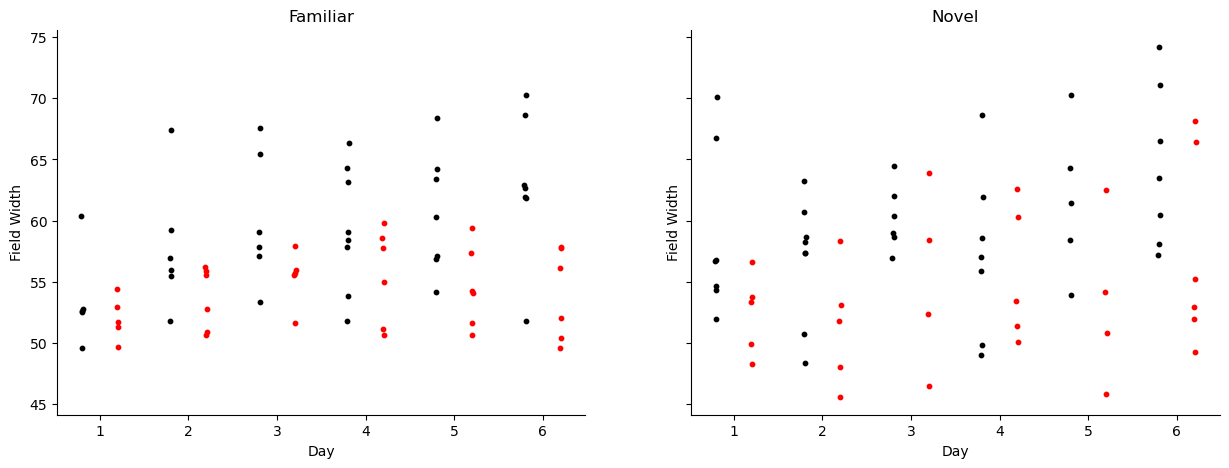

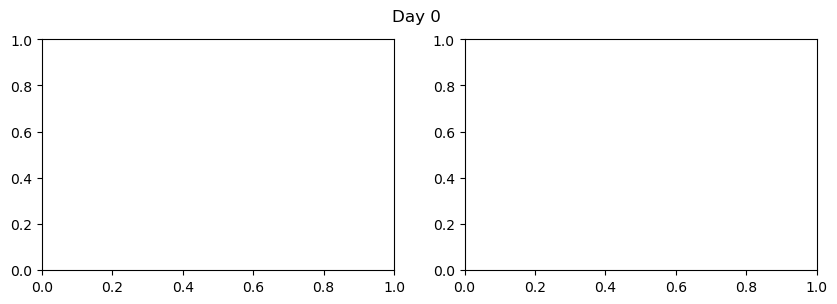

In [39]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary.pdf"))


# single day, across mouse histograms
bin_edges = np.arange(30,210, 10)
for day in range(6):
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        
        ctrl_width = []
        for mouse in ctrl_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            ctrl_width.append(f_info[:,2].ravel())
            # ctrl_width.append(10*field_stats[mouse][day][ttype]['field_width'].ravel())
            
        ctrl_width = np.concatenate(ctrl_width)
        
        ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
        
        ko_width = []
        for mouse in ko_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            ko_width.append(f_info[:,2].ravel())
            # ko_width.append(10*field_stats[mouse][day][ttype]['field_width'].ravel())
            
        ko_width = np.concatenate(ko_width)
        print(ko_width)
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('Field Width')
        ax[ax_ind].set_xlim(30,210)
        
        # fig.savefig(os.path.join(figdir, f"day{day}_field_width_hist.pdf"))


print('Familiar ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='fam') & (df['day']<5)], dv='field_width', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[df['ttype']=='fam'], dv='field_width', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

print('Novel ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='nov') & (df['day']<5)], dv='field_width', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[df['ttype']=='nov'], dv='field_width', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)


Skipping cre mouse 4467975.1, day 0, ttype fam: 'field_info'
Skipping cre mouse 4467975.2, day 0, ttype fam: 'field_info'
Skipping cre mouse 4467975.1, day 0, ttype nov: 'field_info'
Skipping cre mouse 4467975.2, day 0, ttype nov: 'field_info'
Skipping cre mouse 4467975.2, day 1, ttype fam: 'field_info'
Skipping cre mouse 4467975.2, day 1, ttype nov: 'field_info'
Skipping ctrl mouse 4467332.2, day 2, ttype fam: 'field_info'
Skipping cre mouse 4467975.2, day 2, ttype fam: 'field_info'
Skipping ctrl mouse 4467332.2, day 2, ttype nov: 'field_info'
Skipping cre mouse 4467975.2, day 2, ttype nov: 'field_info'
Skipping cre mouse 4467975.2, day 3, ttype fam: 'field_info'
Skipping cre mouse 4467975.2, day 3, ttype nov: 'field_info'
Skipping ctrl mouse 4467332.2, day 4, ttype fam: 'field_info'
Skipping ctrl mouse mCherry9, day 4, ttype fam: 'field_info'
Skipping cre mouse 4467975.2, day 4, ttype fam: 'field_info'
Skipping ctrl mouse 4467332.2, day 4, ttype nov: 'field_info'
Skipping ctrl mouse 

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\parametric.py:257: RuntimeWarning: Degrees of freedom <= 0 for slice
  vx, vy = x.var(ddof=1), y.var(ddof=1)
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\effsize.py:802: RuntimeWarning: Degrees of freedom <= 0 for slice
  poolsd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
C:\Use

      Contrast day    A     B Paired  Parametric         T  dof alternative  \
0          day   -    0     1   True        True -0.658412  3.0   two-sided   
1          day   -    0     2   True        True -1.688959  3.0   two-sided   
2          day   -    0     3   True        True -0.620286  3.0   two-sided   
3          day   -    0     4   True        True -1.627538  3.0   two-sided   
4          day   -    0     5   True        True -2.071546  3.0   two-sided   
5          day   -    1     2   True        True -1.028833  3.0   two-sided   
6          day   -    1     3   True        True -0.163274  3.0   two-sided   
7          day   -    1     4   True        True -1.543246  3.0   two-sided   
8          day   -    1     5   True        True -1.889502  3.0   two-sided   
9          day   -    2     3   True        True  1.378394  3.0   two-sided   
10         day   -    2     4   True        True  0.320346  3.0   two-sided   
11         day   -    2     5   True        True -1.

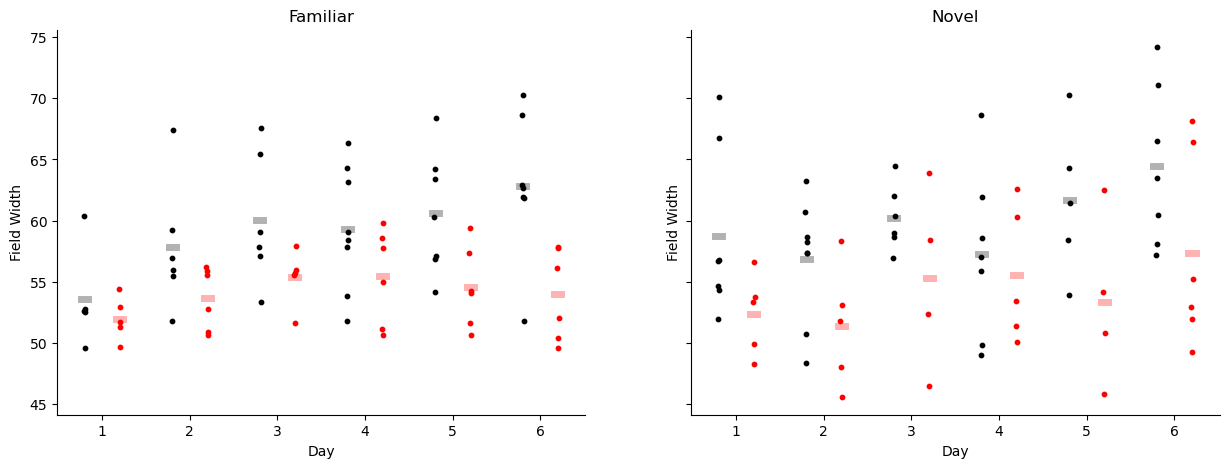

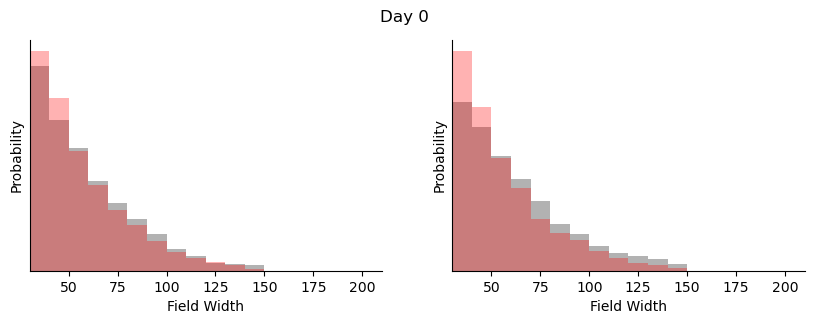

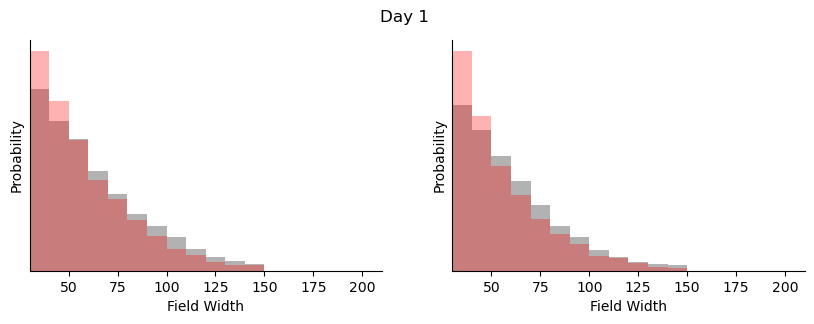

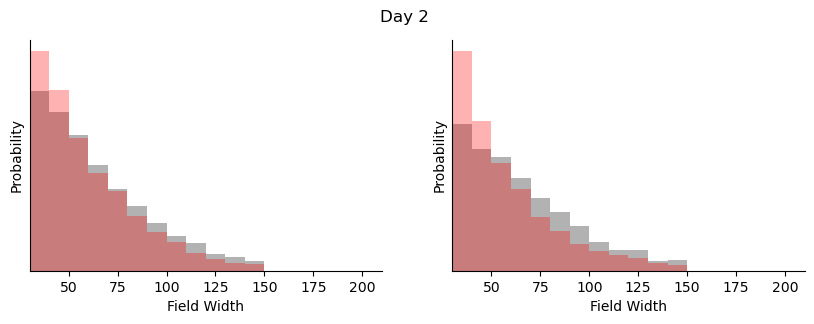

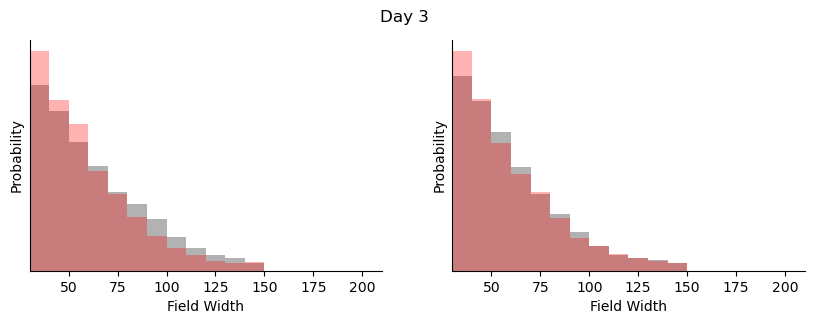

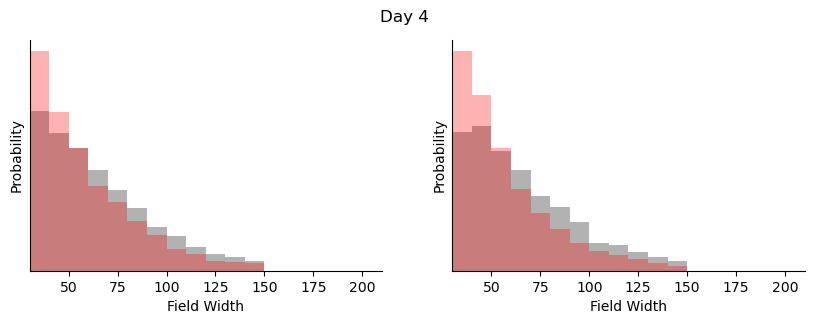

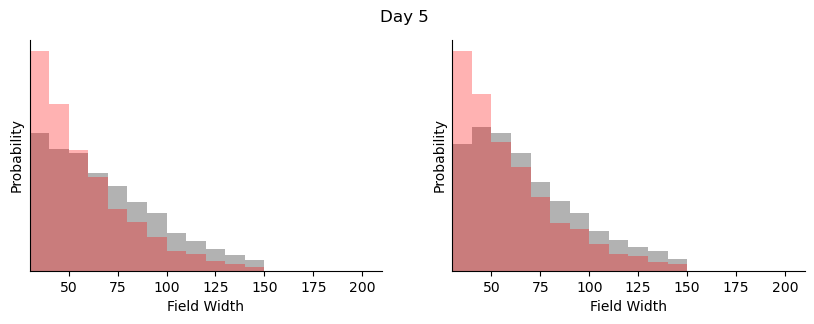

In [40]:
## added crash prevention for missing data

fig, ax = plt.subplots(1, 2, figsize=[15, 5], sharey=True)

# Population plots
for day in range(6):
    for cond, color, offset in [('ctrl', 'black', -1), ('cre', 'red', 1)]:
        for ttype, ax_idx in [('fam', 0), ('nov', 1)]:
            try:
                mask = (df['cond'] == cond) & (df['day'] == day) & (df['ttype'] == ttype)
                fw = 10. * df['field_width'].loc[mask]._values
                if fw.size == 0 or np.isnan(fw).all():
                    continue  # skip empty or all-NaN
                x_vals = 5 * day + offset + np.linspace(-0.05, 0.05, num=fw.shape[0])
                ax[ax_idx].scatter(x_vals, fw, color=color, s=s)
                ax[ax_idx].plot(5 * day + offset + np.array([-0.2, .2]),
                                np.nanmean(fw) * np.ones(2), color=color, linewidth=lw, alpha=.3)
            except Exception as e:
                print(f"Skipping plot point for {cond}, {ttype}, day {day}: {e}")

ax[0].set_title('Familiar')
ax[1].set_title('Novel')

for a in range(2):
    ax[a].set_xticks(np.arange(0, 6 * 5, 5))
    ax[a].set_xticklabels([x for x in range(1, 7)])
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')

# Single-day, across-mouse histograms
bin_edges = np.arange(30, 210, 10)
for day in range(6):
    fig, ax = plt.subplots(1, 2, figsize=[10, 3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):

        ctrl_width = []
        for mouse in ctrl_mice:
            try:
                f_info = np.array(field_stats[mouse][day][ttype]['field_info'])
                if f_info.size > 0:
                    ctrl_width.append(10 * f_info[:, 2].ravel())
            except Exception as e:
                print(f"Skipping ctrl mouse {mouse}, day {day}, ttype {ttype}: {e}")

        if ctrl_width:
            ctrl_width = np.concatenate(ctrl_width)
            ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)

        ko_width = []
        for mouse in ko_mice:
            try:
                f_info = np.array(field_stats[mouse][day][ttype]['field_info'])
                if f_info.size > 0:
                    ko_width.append(10 * f_info[:, 2].ravel())
            except Exception as e:
                print(f"Skipping cre mouse {mouse}, day {day}, ttype {ttype}: {e}")

        if ko_width:
            ko_width = np.concatenate(ko_width)
            ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('Field Width')
        ax[ax_ind].set_xlim(30, 210)

# Stats (only on valid data)
print('Familiar ANOVA')
try:
    aov = mixed_anova(data=df.loc[(df['ttype'] == 'fam') & (df['day'] < 5)], dv='field_width',
                      between='cond', within='day', subject='mouse')
    print(aov)
    posthoc = pairwise_tests(data=df.loc[df['ttype'] == 'fam'], dv='field_width',
                             between='cond', within='day', subject='mouse', padjust='holm')
    print(posthoc)
except Exception as e:
    print(f"Error in Familiar ANOVA/posthoc: {e}")

print('Novel ANOVA')
try:
    aov = mixed_anova(data=df.loc[(df['ttype'] == 'nov') & (df['day'] < 5)], dv='field_width',
                      between='cond', within='day', subject='mouse')
    print(aov)
    posthoc = pairwise_tests(data=df.loc[df['ttype'] == 'nov'], dv='field_width',
                             between='cond', within='day', subject='mouse', padjust='holm')
    print(posthoc)
except Exception as e:
    print(f"Error in Novel ANOVA/posthoc: {e}")


Text(0.5, 0, 'Day')

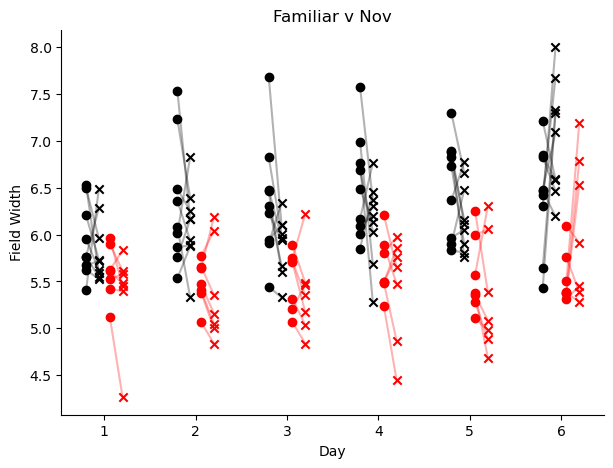

In [10]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ctrl_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ko_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Field Width')
ax.set_xlabel('Day')
    
# fig.savefig(os.path.join(figdir,"log_activity_rate_summary_within_group.pdf"),format='pdf')

Familiar ANOVA
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0         cond  0.238159    1   14  0.238159  26.415589  0.000150  0.653599   
1          day  0.007941    4   56  0.001985   0.794323  0.533880  0.053691   
2  Interaction  0.034911    4   56  0.008728   3.492326  0.012905  0.199649   

        eps  
0       NaN  
1  0.639672  
2       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -1.168329  15.000000   
1          day   -    0     2   True        True -0.687721  15.000000   
2          day   -    0     3   True        True -0.788464  15.000000   
3          day   -    0     4   True        True -1.115008  15.000000   
4          day   -    0     5   True        True -0.869163  15.000000   
5          day   -    1     2   True        True  0.726778  15.000000   
6          day   -    1     3   True        True  0.372750  15.000000   
7          day   -    1     

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "B"] = B
/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/pingouin/pairwise.py:583: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the ol

      Contrast day    A     B Paired  Parametric          T        dof  \
0          day   -    0     1   True        True   0.247702  15.000000   
1          day   -    0     2   True        True  -0.447787  15.000000   
2          day   -    0     3   True        True  -0.172968  15.000000   
3          day   -    0     4   True        True  -0.138147  15.000000   
4          day   -    0     5   True        True  11.174633  15.000000   
5          day   -    1     2   True        True  -0.770260  15.000000   
6          day   -    1     3   True        True  -0.434213  15.000000   
7          day   -    1     4   True        True  -0.357893  15.000000   
8          day   -    1     5   True        True  10.396137  15.000000   
9          day   -    2     3   True        True   0.354792  15.000000   
10         day   -    2     4   True        True   0.306710  15.000000   
11         day   -    2     5   True        True  12.058511  15.000000   
12         day   -    3     4   True  

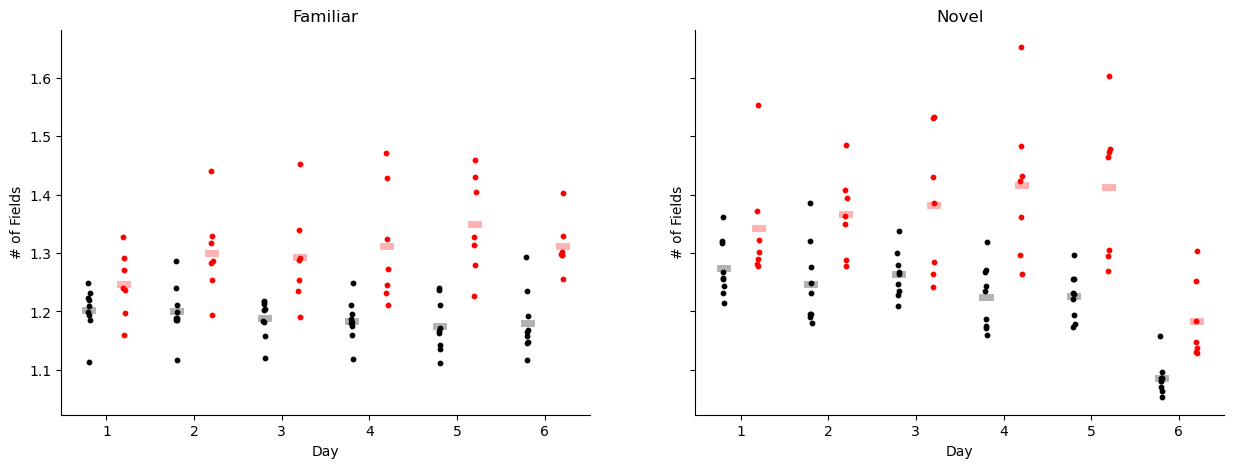

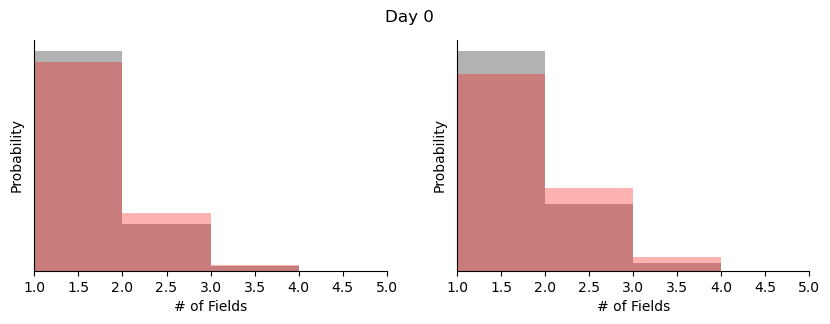

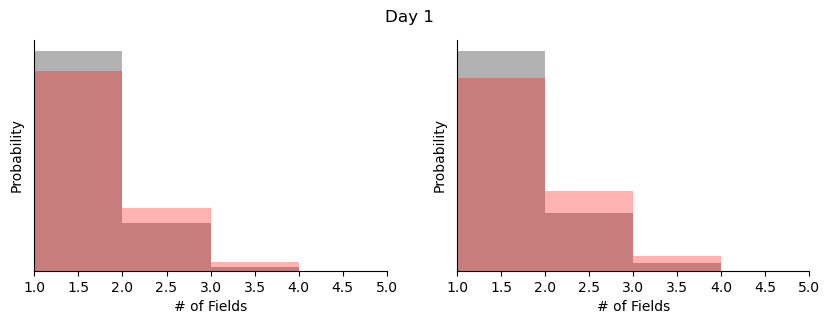

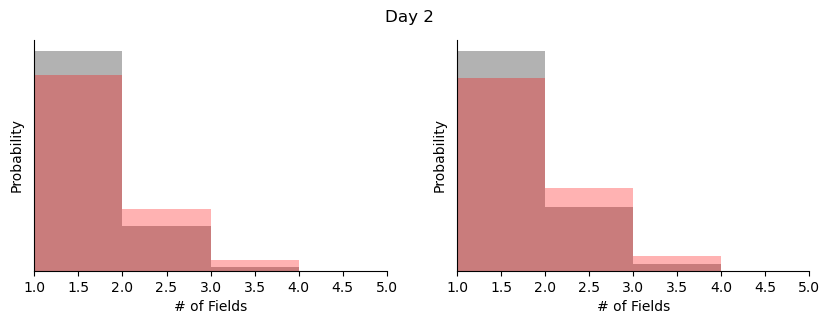

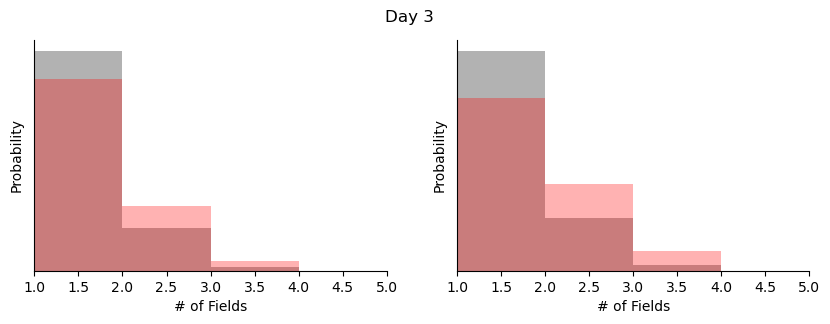

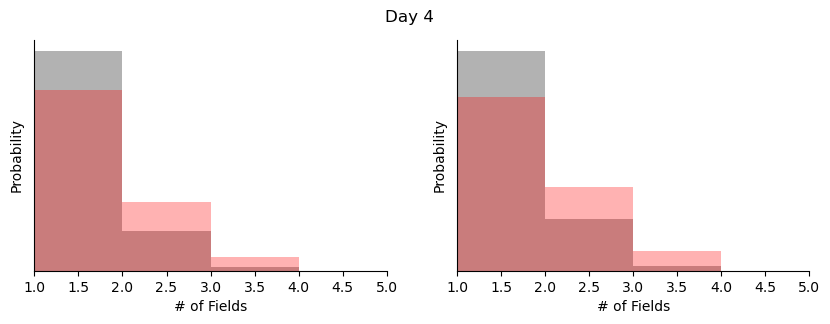

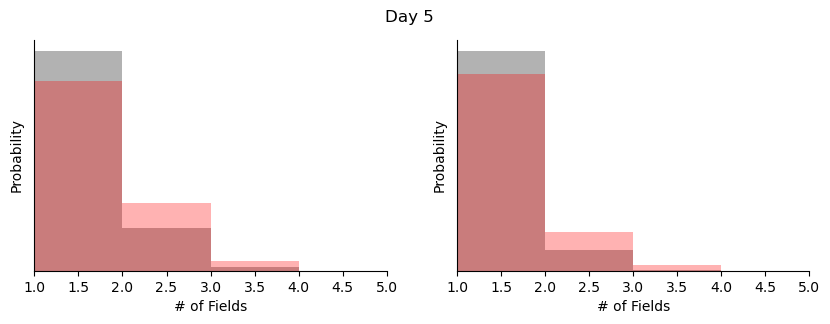

In [13]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('# of Fields')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "num_fields_across_mouse_summary.pdf"))



# single day, across mouse histograms
bin_edges = np.arange(0,5, 1)
for day in range(6):
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        
        ctrl_width = []
        for mouse in ctrl_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
            
            ctrl_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
            
        ctrl_width = np.concatenate(ctrl_width)
        
        ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
        
        ko_width = []
        for mouse in ko_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
                
            ko_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
        ko_width = np.concatenate(ko_width)
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('# of Fields')
        ax[ax_ind].set_xlim(1,5)
        
        # fig.savefig(os.path.join(figdir, f"day{day}_num_fields_hist.pdf"))


print('Familiar ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='fam') & (df['day']<5)], dv='n_fields', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[(df['ttype']=='fam')], dv='n_fields', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

print('Novel ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='nov') & (df['day']<5)], dv='n_fields', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[(df['ttype']=='nov')], dv='n_fields', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)



Text(0.5, 0, 'Day')

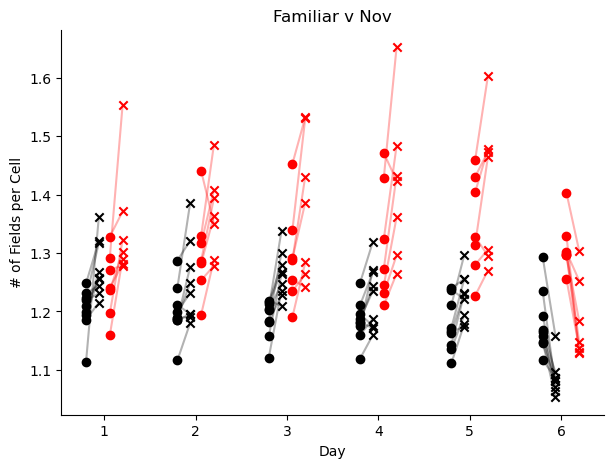

In [12]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ctrl_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['n_fields'].loc[_df['ttype']=='fam']._values, _df['n_fields'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ko_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['n_fields'].loc[_df['ttype']=='fam']._values, _df['n_fields'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('# of Fields per Cell')
ax.set_xlabel('Day')